<a href="https://colab.research.google.com/github/tizianofucci/A2NDLVisualQuestionAnswering/blob/master/Notebook/local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  

In [ ]:
cwd = os.getcwd()

In [ ]:
labels_dict  = {
        '0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        'apple': 6,
        'baseball': 7,
        'bench': 8,
        'bike': 9,
        'bird': 10,
        'black': 11,
        'blanket': 12,
        'blue': 13,
        'bone': 14,
        'book': 15,
        'boy': 16,
        'brown': 17,
        'cat': 18,
        'chair': 19,
        'couch': 20,
        'dog': 21,
        'floor': 22,
        'food': 23,
        'football': 24,
        'girl': 25,
        'grass': 26,
        'gray': 27,
        'green': 28,
        'left': 29,
        'log': 30,
        'man': 31,
        'monkey bars': 32,
        'no': 33,
        'nothing': 34,
        'orange': 35,
        'pie': 36,
        'plant': 37,
        'playing': 38,
        'red': 39,
        'right': 40,
        'rug': 41,
        'sandbox': 42,
        'sitting': 43,
        'sleeping': 44,
        'soccer': 45,
        'squirrel': 46,
        'standing': 47,
        'stool': 48,
        'sunny': 49,
        'table': 50,
        'tree': 51,
        'watermelon': 52,
        'white': 53,
        'wine': 54,
        'woman': 55,
        'yellow': 56,
        'yes': 57
}


# Example: Image Segmentation
## Build segmentation

In [ ]:
import shutil
import random
import json
import math

SEED = 1234
tf.random.set_seed(SEED)  

# Get current working directory
cwd = os.path.join(os.path.dirname(os.getcwd()),"VQA_Dataset")

#Save all possible path in order to be able to cycle over them
dataset_image_dir = os.path.join(cwd,'Images')

dataset_QA = os.path.join(cwd,'train_questions_annotations.json')

test_QA = os.path.join(cwd,'test_questions.json')


In [ ]:
print(dataset_QA)
print(test_QA)

C:\Users\ASUS\Documents\Università\ANNDL\A2NDLVisualQuestionAnswering\VQA_Dataset\train_questions_annotations.json
C:\Users\ASUS\Documents\Università\ANNDL\A2NDLVisualQuestionAnswering\VQA_Dataset\test_questions.json


In [ ]:
with open(dataset_QA) as f:
    q_dict = json.load(f)

In [ ]:
for key in q_dict:
#     q_dict[key]['answer'] = labels_dict[q_dict[key]['answer']]
    print(q_dict[key]['answer'])

man
blanket
bench
yes
man
no
yes
brown
no
no
yes
no
no
1
gray
yes
yes
no
yes
no
soccer
yes
no
3
playing
sitting
food
no
2
man
yes
no
orange
no
1
yes
blanket
2
1
no
red
yellow
no
no
2
no
blue
red
2
2
baseball
yes
yes
nothing
dog
no
yes
no
no
yes
tree
2
stool
yes
no
yes
yes
no
1
yes
yes
2
yes
2
brown
yes
red
yes
yes
red
1
no
yes
1
0
no
red
no
3
2
no
yes
no
yes
woman
log
yes
no
tree
bike
yes
sitting
yellow
no
yes
2
3
no
no
floor
stool
yes
yes
2
yes
yes
yes
yes
red
no
no
no
no
1
no
yes
yes
yes
no
red
yes
yes
no
4
yes
yes
2
nothing
table
1
orange
no
no
standing
red
2
yes
4
no
yes
no
yellow
no
no
yes
no
2
brown
yes
2
blue
2
yes
sleeping
no
plant
apple
black
yes
no
no
yes
no
no
blue
yes
squirrel
3
4
soccer
no
orange
yes
yes
yes
no
grass
yes
left
yes
no
yes
bone
no
yellow
orange
no
no
red
girl
2
no
red
yes
2
white
log
yes
white
yellow
2
no
yes
yes
1
5
table
2
no
wine
yes
yes
blue
no
1
2
1
yes
4
table
red
1
yes
yes
2
no
nothing
no
couch
no
2
1
yes
yes
yes
yes
blue
3
5
5
0
brown
red
sandbox
yes


yes
3
white
yes
red
2
3
4
standing
no
yes
yes
no
yes
yes
grass
2
0
yes
yes
yes
yes
2
yellow
red
1
1
yes
no
1
red
no
yes
yellow
white
woman
yes
yes
2
yes
no
yes
yes
no
food
yes
no
yes
red
yes
cat
red
yes
1
green
yes
green
no
gray
nothing
2
1
yes
yes
yes
yes
no
no
wine
dog
no
yes
no
1
left
brown
no
yes
3
yes
white
yes
girl
no
brown
2
no
no
1
yes
gray
no
no
2
2
dog
yes
football
blue
no
3
no
1
yes
2
gray
yes
nothing
5
2
sitting
no
1
no
3
yes
no
floor
yes
yes
yes
yes
tree
no
no
blanket
3
white
1
dog
2
no
no
yes
2
no
red
yes
sunny
no
yes
no
yes
red
no
yes
white
no
no
girl
no
no
0
2
1
sitting
3
yes
yes
yes
yes
2
yes
white
1
white
bench
red
yes
football
yes
white
no
1
2
1
yes
bike
no
5
yes
yes
no
yes
no
no
1
yes
yes
yes
yes
yes
red
no
right
table
1
yes
red
3
3
white
yes
1
white
yes
standing
no
no
yes
0
yes
watermelon
yes
cat
yes
1
yes
yes
yes
1
1
2
no
2
blue
no
food
3
no
no
white
yes
yes
no
yes
no
yes
yes
no
football
yes
pie
food
yes
no
white
yes
yes
no
red
yes
red
no
wine
brown
no
nothing
pla

no
yes
no
no
brown
yes
3
yes
0
no
yes
wine
yellow
1
black
bird
brown
yes
soccer
no
no
yes
no
yes
4
man
yes
no
yes
1
tree
yes
yes
no
yes
tree
2
yes
brown
red
yes
yellow
red
green
white
no
yes
watermelon
yes
yellow
no
no
no
yes
dog
2
2
soccer
yes
yes
yes
yes
yes
rug
yes
no
yes
2
no
no
yes
no
1
no
brown
yes
no
2
yes
yes
2
yellow
no
red
no
no
baseball
5
soccer
yes
no
5
yes
yes
no
yes
no
football
yes
yes
yes
2
2
1
yes
no
3
1
no
yes
orange
yes
no
5
0
no
yellow
yes
2
yes
5
man
no
2
3
2
yes
white
2
sleeping
standing
blue
cat
no
no
orange
yes
no
no
no
yes
brown
no
yes
no
no
yes
playing
yes
2
yes
yes
1
yes
2
no
no
green
yes
4
yes
plant
yes
yes
no
boy
1
no
2
no
brown
no
2
yes
yes
no
no
no
dog
0
yes
yes
black
3
yellow
1
blue
couch
yes
no
yes
2
red
no
green
no
no
cat
no
food
2
yes
yes
bench
no
no
yes
no
0
yes
table
yes
bird
no
yes
brown
wine
sitting
1
brown
no
yes
2
yes
red
yellow
woman
no
bike
brown
yes
yes
1
playing
soccer
yes
2
yes
yes
gray
4
sitting
no
no
yes
white
wine
cat
yes
2
dog
left
couch

yes
right
sandbox
yes
yes
2
red
brown
yes
yes
yes
2
baseball
tree
pie
3
no
no
blue
no
1
yes
yes
yes
4
green
3
yes
yes
yes
yes
no
no
yes
yes
yes
no
blue
yes
red
yes
no
yes
apple
yes
2
yes
yes
yes
yes
yes
monkey bars
red
no
no
yes
no
dog
yes
no
no
no
no
yes
2
4
2
sitting
2
yes
yes
yes
2
red
1
no
yes
no
yes
no
yes
yes
2
right
yes
yes
monkey bars
no
plant
yes
yes
no
yes
yes
no
no
no
0
yes
left
yes
no
no
yes
football
red
no
white
book
no
no
nothing
yes
yes
tree
yes
standing
2
no
no
bird
watermelon
no
no
1
no
yes
3
no
yes
2
no
red
no
dog
red
no
yes
no
5
no
no
2
no
blanket
yes
yes
no
yes
pie
yes
0
1
right
red
blue
no
yes
no
yes
no
yes
yes
orange
2
4
white
4
blanket
no
0
yes
watermelon
yes
no
2
brown
2
no
4
yes
couch
left
no
yes
yes
yes
yes
rug
no
no
no
woman
brown
red
2
plant
no
yes
yes
floor
yes
yes
yes
green
no
2
no
4
red
2
red
yes
no
no
squirrel
wine
white
no
white
no
yes
red
no
no
table
right
no
tree
squirrel
baseball
1
yes
4
gray
no
blue
yes
sunny
yes
2
yes
no
orange
bench
yes
no
tree
gr

yes
2
yes
food
left
no
no
cat
4
no
3
sitting
2
soccer
no
right
2
no
yes
yes
red
no
3
2
yes
yes
dog
yes
2
yes
yes
yes
yes
red
sandbox
yes
yes
yes
red
yes
no
yes
yes
no
2
2
no
no
girl
3
no
3
2
white
yes
no
food
no
5
0
blue
2
no
floor
green
grass
yes
yes
1
yes
no
no
no
1
yes
no
no
no
yellow
2
no
bike
black
tree
1
no
no
no
monkey bars
3
no
bike
yes
brown
brown
red
yes
couch
yes
red
yes
yes
white
no
sandbox
4
yes
table
yes
2
book
red
yes
boy
grass
2
bone
no
watermelon
2
2
plant
dog
no
black
yes
yes
2
rug
yellow
red
yes
white
yes
yes
2
2
plant
no
bone
yes
no
no
5
book
plant
no
yes
yes
no
yes
table
football
yes
no
food
1
red
no
no
no
no
no
yes
yes
yes
no
yes
football
no
1
2
no
dog
book
no
no
2
yes
1
yes
sandbox
4
yes
0
3
bench
no
red
2
orange
yellow
1
cat
no
yes
yellow
no
yes
1
no
3
no
black
green
no
yes
no
brown
blue
yes
soccer
yes
2
3
yes
2
yes
no
yes
no
4
5
yes
black
yes
2
2
yes
no
no
sunny
no
blue
yes
monkey bars
sunny
5
1
no
yes
yellow
yes
yes
nothing
2
sitting
no
1
yes
no
red
yes
yes
ye

2
standing
red
white
sunny
soccer
yes
5
apple
yes
yes
no
yes
2
no
sitting
dog
no
yes
yes
yes
red
5
sunny
yes
yes
no
yellow
baseball
no
playing
no
yes
yes
2
0
plant
yes
soccer
sitting
yes
red
yes
red
brown
green
girl
yes
2
man
yes
yes
yes
yes
no
1
no
red
yes
red
3
yes
1
3
sitting
no
plant
no
yes
2
2
1
no
brown
man
yes
yes
yes
sitting
yes
yes
2
no
bench
yes
dog
no
red
2
2
yes
no
yes
no
2
2
yes
no
nothing
yes
couch
yes
yes
book
2
yes
no
yes
bone
gray
no
3
sleeping
black
1
1
no
yes
no
baseball
baseball
yes
no
left
black
yes
food
no
1
yes
yes
black
yes
woman
yes
yellow
man
green
brown
yes
yes
2
yes
no
red
2
no
yes
brown
2
monkey bars
yes
couch
dog
no
2
0
no
yes
no
log
2
no
yes
right
dog
1
yellow
no
no
boy
yes
no
yes
no
2
yes
yes
watermelon
no
yes
orange
no
chair
black
nothing
red
4
food
no
bird
no
1
dog
yes
dog
brown
monkey bars
yes
2
floor
yes
yellow
yes
football
football
yes
2
grass
yes
food
yes
standing
yes
no
3
no
1
2
no
yes
tree
no
5
2
no
no
playing
2
white
brown
book
yes
1
no
5
yes
bo

couch
1
yes
yes
red
no
football
0
no
yes
no
brown
dog
rug
1
yes
dog
blue
sandbox
yellow
1
yes
2
1
red
green
right
2
watermelon
2
no
no
no
no
wine
yes
yes
no
yes
yes
no
yes
red
no
girl
1
no
left
no
yes
yes
left
yes
woman
gray
white
no
yes
football
no
2
white
1
wine
white
no
yes
no
white
2
sitting
yes
yes
yes
no
2
4
woman
no
yes
yes
yes
no
no
no
2
no
yes
2
no
playing
yes
yes
yes
yes
orange
yes
no
blanket
yes
yes
yes
red
yes
2
1
no
2
table
no
no
no
no
yes
no
1
yes
soccer
0
2
yes
no
playing
floor
yes
2
1
yes
bike
yes
no
yes
yes
boy
red
football
right
pie
no
yes
playing
black
playing
no
cat
no
bike
orange
yes
no
no
2
0
yes
2
0
yes
no
red
5
4
no
yes
rug
yes
yes
red
no
football
nothing
red
no
right
white
yes
yes
red
no
sleeping
4
no
yes
blue
floor
couch
4
yes
no
yes
chair
orange
1
no
no
couch
sleeping
4
yes
no
wine
yes
no
yes
yes
yes
1
blanket
yes
bird
1
no
no
yes
red
no
cat
yes
yellow
yes
playing
yes
2
cat
yes
yes
no
3
5
yes
watermelon
watermelon
orange
no
no
monkey bars
no
bird
red
yes
floo

2
no
no
1
white
yes
yes
yes
2
bike
no
yes
yes
yes
1
yes
man
2
2
yellow
yes
no
yellow
yes
yes
4
1
no
cat
yes
no
yes
yes
yes
no
green
no
no
yes
yes
yes
2
yes
no
yes
brown
yes
yes
pie
2
yes
yes
no
sleeping
man
no
yes
1
bone
chair
yes
sleeping
no
blue
yes
2
bike
no
yes
man
yes
yes
no
yes
yes
yes
no
yes
white
1
yes
yes
table
no
yes
no
sitting
2
green
sandbox
yes
2
yes
yes
yes
no
no
yes
yes
white
3
red
yes
no
blanket
yellow
yes
yes
no
2
no
no
no
no
yellow
2
no
yes
yes
yes
yes
no
red
yes
no
soccer
log
yes
yes
yes
2
no
2
dog
bike
yes
yes
floor
yes
white
no
no
blanket
bike
yes
4
white
right
brown
no
yes
yes
1
no
no
no
yes
yes
1
no
no
3
yes
2
2
blue
yes
no
2
yes
sleeping
yes
yes
no
no
yes
red
no
1
yes
yes
no
yes
no
yes
yes
yes
yes
3
yes
yes
yes
no
yes
no
2
pie
yes
2
no
yes
yes
no
no
no
yes
yellow
blanket
1
1
no
1
2
yes
no
yes
white
0
book
yes
no
2
no
yes
no
sleeping
yes
nothing
1
yes
no
no
2
yes
yes
no
yes
no
no
3
2
5
yes
yes
couch
no
1
yellow
yes
blue
rug
no
yes
squirrel
no
blue
yes
no
yes
yes


yes
no
dog
white
yellow
2
yes
no
yes
bird
bench
dog
1
green
no
boy
1
0
1
brown
no
girl
yes
playing
yes
red
0
no
3
yes
yellow
yes
no
yes
no
no
yes
yes
white
3
yes
yes
2
white
no
watermelon
2
yes
no
2
woman
squirrel
monkey bars
no
blue
1
no
green
yes
0
yes
4
no
yes
no
yes
plant
2
sitting
rug
no
yes
white
yes
black
no
1
1
0
sleeping
plant
yes
dog
girl
yes
brown
2
yes
no
2
no
yes
yes
couch
no
yes
yes
nothing
standing
yes
yes
yes
yes
2
no
sleeping
apple
sunny
no
no
plant
bench
3
yes
yes
yes
2
yes
yes
1
no
yes
no
yes
wine
yes
3
no
yes
no
wine
no
3
3
4
nothing
1
no
cat
2
yes
no
floor
3
sandbox
yellow
no
no
no
yes
2
1
2
no
yes
sandbox
yes
red
yes
yellow
no
yes
watermelon
2
1
no
yes
yes
yes
no
yes
black
yes
grass
2
2
yes
yes
no
no
yes
sitting
no
soccer
yes
yes
4
no
no
soccer
dog
yes
yes
no
blue
1
log
nothing
soccer
yes
yes
tree
yes
yes
3
playing
no
bike
wine
yes
0
3
no
left
gray
no
floor
1
boy
no
no
no
yes
yes
red
girl
yes
no
yes
no
2
no
yes
0
red
chair
yes
yes
bike
2
woman
red
2
1
no
soccer
3


no
table
4
yes
1
black
1
white
1
2
2
table
cat
yes
squirrel
playing
brown
yes
yes
apple
no
white
chair
blanket
red
no
yes
blue
5
no
2
yes
wine
2
yes
no
yes
yes
no
yes
1
yes
white
1
green
2
red
yes
football
no
yes
food
yellow
no
table
2
1
no
2
no
couch
yes
2
rug
standing
floor
yes
no
yes
yes
2
red
yes
4
yes
gray
no
sitting
3
yes
tree
0
yes
white
no
yes
blue
3
1
no
yes
no
yes
blue
no
no
3
no
yes
yes
yes
yes
yes
no
3
no
yes
yes
yes
yes
0
yes
yes
no
yes
yes
yes
yes
yes
2
no
yes
girl
no
1
yes
no
no
plant
no
plant
no
yes
2
yes
no
couch
yes
yes
red
yes
yes
plant
watermelon
yes
dog
no
no
table
brown
yes
white
right
red
5
yes
yes
no
no
wine
dog
blue
yes
yes
2
yes
yellow
bone
plant
1
yes
yes
2
yes
cat
yes
yes
yes
food
sitting
red
floor
no
5
standing
no
no
white
no
yes
sleeping
sandbox
yes
no
yes
yes
yes
bench
blanket
yes
log
wine
2
yes
yes
4
2
no
no
yes
2
left
2
right
bird
yes
no
no
yes
no
right
no
yes
yes
yes
no
orange
yellow
white
3
yes
no
white
no
no
no
yes
no
red
food
yes
no
3
3
no
yes
yes
y

1
yellow
no
no
yes
yes
2
yes
1
red
no
no
cat
yes
floor
yes
yes
no
red
couch
woman
2
no
brown
log
yes
yes
no
no
yes
2
no
bone
red
yes
girl
no
sleeping
no
white
stool
yes
yes
yes
yes
watermelon
yes
monkey bars
sandbox
2
2
no
no
no
watermelon
yes
no
standing
rug
blue
no
2
2
1
red
bird
2
4
dog
green
yes
1
2
yes
no
1
squirrel
3
5
2
no
table
white
1
no
cat
1
gray
yes
red
bone
no
yes
red
no
baseball
yes
4
sitting
yes
yes
no
white
sandbox
boy
yes
red
floor
yes
no
yes
no
yes
yes
no
playing
no
2
dog
yes
no
no
no
monkey bars
yes
yes
red
2
rug
red
yellow
no
2
sleeping
1
2
red
yes
yes
no
no
no
no
blue
right
yes
2
yes
no
yes
yes
no
apple
yes
no
brown
dog
yes
red
playing
1
no
no
yes
blue
4
5
log
no
yes
green
white
white
yes
no
yes
2
man
no
1
2
4
grass
stool
yes
yes
blanket
no
yes
no
no
yes
black
yes
sandbox
black
3
yes
apple
sandbox
no
yes
yes
monkey bars
soccer
yes
red
apple
yes
yes
yes
yes
no
no
no
no
3
book
yes
red
no
yes
yes
3
couch
2
no
brown
no
1
plant
2
no
yes
yes
no
squirrel
red
yes
yellow
no

blanket
yes
no
no
yes
yes
table
no
no
4
no
2
no
no
1
yes
yes
soccer
3
grass
yes
yes
yes
no
yes
wine
2
table
no
couch
yes
yes
3
2
5
2
yes
bench
blue
1
yes
yes
no
yes
yes
blue
4
2
no
4
yellow
yes
yes
girl
2
brown
yes
black
yes
wine
yes
tree
no
bike
no
no
yes
3
blue
no
no
yes
no
yes
red
yes
green
yes
cat
yes
woman
3
bone
green
brown
floor
yes
white
yes
yes
2
1
yes
red
3
log
3
1
cat
yes
2
yes
yes
2
1
white
brown
no
4
no
3
yes
1
yes
yes
yes
5
yes
no
no
monkey bars
no
green
yes
1
white
no
3
sleeping
yes
5
yes
5
yes
no
yes
pie
cat
1
1
no
yes
yes
right
yes
brown
no
yes
bench
yes
floor
cat
apple
4
white
yes
red
1
blue
yes
table
cat
no
cat
orange
orange
chair
book
no
2
white
no
dog
no
no
no
no
yes
2
yes
3
no
yes
1
0
dog
bench
yes
2
yes
yes
yes
1
2
no
dog
plant
no
yes
no
woman
monkey bars
no
4
sitting
4
no
no
no
bone
yes
yes
3
2
2
white
no
no
yes
white
yes
yes
yes
no
yes
no
yes
white
2
yes
right
1
no
no
black
right
no
no
yes
3
wine
yes
red
playing
yellow
no
woman
no
watermelon
woman
yes
2
yes
1
r

yellow
bike
red
orange
2
no
pie
pie
2
3
no
table
yes
yes
yes
yes
3
football
football
blue
yes
yes
2
yes
no
yes
3
dog
3
yes
yes
no
2
yellow
2
playing
yes
no
yes
yes
gray
no
3
2
sitting
sitting
brown
yes
yes
no
no
no
blue
1
3
sitting
red
yellow
yes
yes
boy
blanket
man
gray
red
blanket
red
red
yes
no
no
no
yes
yes
no
no
sitting
boy
tree
no
no
yellow
soccer
no
dog
2
2
3
yes
no
1
yes
apple
food
no
soccer
no
2
table
2
yes
blanket
couch
yes
no
no
yes
2
0
yes
yes
yes
yes
yes
3
yellow
gray
yes
0
2
baseball
baseball
yes
blue
2
2
sitting
red
no
yellow
chair
no
no
1
yes
no
yes
2
no
girl
cat
2
blue
yes
bike
yes
yes
baseball
yes
no
right
no
yes
yes
yes
1
yes
yes
orange
squirrel
2
yes
white
no
no
yes
yes
right
yes
white
2
2
cat
woman
2
4
gray
gray
no
girl
yes
yes
no
red
yes
yes
3
yes
yes
yes
yes
no
yes
yes
food
yes
yellow
2
yellow
yes
yes
no
dog
book
no
yes
yes
yes
3
no
no
yes
2
monkey bars
yes
no
no
yes
girl
yes
no
1
1
yes
yes
red
white
white
no
2
yes
yes
no
yes
black
blanket
no
yes
2
yes
2
green
ye

yes
2
4
no
floor
red
1
1
table
1
2
red
yes
grass
left
sitting
white
white
football
woman
red
no
no
blue
no
no
3
no
yes
1
bike
yellow
yes
yes
yes
yes
yes
no
1
2
red
2
2
yes
yes
yes
no
dog
no
no
yes
no
yes
3
plant
yes
no
yes
man
3
yellow
2
no
yes
red
yes
no
5
cat
rug
yes
yes
2
red
grass
gray
no
no
1
no
couch
2
yes
2
no
sitting
no
1
no
yes
1
dog
yes
0
no
yes
2
black
dog
watermelon
yes
no
yes
dog
yes
white
standing
no
yes
yes
no
boy
no
yes
no
0
5
sitting
yes
woman
2
no
red
1
yes
2
no
yes
yes
4
yes
1
no
yes
yes
yes
yes
2
2
no
yes
1
no
no
yes
2
no
yes
2
brown
no
no
couch
yes
no
yes
yes
no
white
no
yes
no
yes
yes
white
3
brown
sitting
yes
no
yes
3
no
red
1
yes
yes
yes
no
no
no
yes
no
yes
tree
yes
yellow
yes
3
grass
dog
yes
no
yes
yes
sunny
no
man
2
nothing
pie
yes
no
no
no
yes
no
no
yes
no
bird
grass
yes
yes
no
no
yes
2
yes
yes
2
yes
green
right
no
yes
3
5
food
4
couch
3
no
no
yes
1
2
yes
soccer
yes
2
yes
yes
1
yes
no
yes
no
white
2
yes
2
no
1
3
4
yes
no
4
grass
blanket
nothing
yes
black
no
n

no
no
2
yes
yes
yes
yes
football
yes
yes
4
yes
yes
no
1
cat
2
1
yes
yes
no
sunny
5
yes
black
no
yellow
no
1
no
2
no
blue
yes
no
2
no
no
yes
yes
yes
bike
yes
brown
yes
wine
0
2
red
dog
yes
yes
1
no
yes
1
yes
yes
orange
orange
green
yes
yes
no
no
yes
2
2
yes
cat
black
gray
no
black
orange
2
1
no
no
no
blue
no
no
yes
white
sunny
3
yes
yes
yes
no
no
yes
3
yellow
yes
3
red
no
sleeping
no
no
no
no
blue
sitting
yes
2
playing
brown
standing
no
yes
yes
yes
yes
yes
yes
no
no
yes
yes
blue
nothing
yes
sandbox
1
no
4
no
yes
yes
blanket
yes
yes
2
sleeping
yes
nothing
2
no
no
yes
2
no
yes
no
yes
blanket
yes
yes
sitting
yes
0
2
couch
yes
no
3
soccer
yes
yes
yes
yes
yes
standing
yes
soccer
yes
blue
sitting
1
log
yes
yes
sitting
no
yes
no
red
yes
2
2
yes
yes
no
yes
no
yes
yes
yes
green
yes
no
5
yes
no
2
no
red
yes
playing
yes
sandbox
yes
yes
no
2
no
no
yes
no
2
right
yes
2
no
table
no
white
no
no
no
blue
yes
sitting
1
sitting
no
white
dog
sandbox
yes
yes
4
white
1
black
2
yes
log
no
yes
blue
sunny
yes
s

yes
grass
no
2
no
tree
no
no
red
yes
no
yes
yes
no
boy
3
yes
yes
white
red
yes
yes
yes
yes
yes
green
no
yes
yes
5
3
wine
yes
no
green
3
yes
table
yes
no
no
yes
2
cat
no
1
no
3
yes
no
2
sunny
yes
yes
2
brown
yes
yes
1
yes
red
3
red
table
yes
1
yes
yes
yes
no
no
yes
yes
no
football
5
brown
yes
brown
yes
no
2
2
yes
no
no
2
2
yes
no
no
no
yes
no
no
yes
1
red
no
no
2
1
yes
3
yes
plant
no
yes
no
red
no
yes
yes
no
yes
right
yes
yes
1
no
no
red
no
yes
yes
no
no
brown
no
yes
no
blanket
0
no
blue
1
dog
yes
yes
no
yes
no
blue
2
white
2
3
0
2
no
1
yes
no
no
table
yes
no
red
2
no
log
yes
no
2
bench
4
no
green
yes
no
sunny
yes
no
1
watermelon
yes
yes
yes
yes
2
red
yes
yes
couch
no
red
yes
red
yes
red
no
yes
no
yes
no
no
yes
no
sitting
no
no
yes
0
black
no
yes
1
2
sitting
no
yes
3
no
no
brown
no
no
yes
no
no
white
cat
red
3
pie
yes
1
no
no
no
yes
couch
yes
2
cat
1
2
no
yes
yes
yes
2
no
right
yes
girl
no
yes
3
no
no
yes
wine
yes
no
football
yes
yes
yes
yes
0
yes
green
red
2
0
red
yes
bone
no
squirrel


yes
yes
3
green
1
sunny
yes
brown
yes
yes
yes
4
no
black
0
yes
dog
yellow
yellow
yes
no
yes
table
2
yes
yes
no
2
blue
no
4
yes
yes
blue
football
floor
girl
5
yes
yes
2
yes
yes
book
sunny
yes
yes
no
white
yes
black
yes
2
no
no
2
red
no
no
couch
no
log
4
no
yes
yes
no
no
yes
playing
no
gray
yes
no
yes
no
yes
no
black
blue
no
no
woman
no
stool
green
no
1
2
no
woman
red
no
1
no
4
no
no
1
no
1
yes
red
1
red
yes
yes
sleeping
2
2
no
yes
no
red
3
yes
red
1
tree
no
woman
yes
2
yes
sitting
yes
woman
yes
1
cat
no
yes
sitting
tree
red
yes
yes
yes
food
orange
watermelon
yes
2
no
blanket
woman
stool
yes
woman
no
yes
4
plant
yes
left
yes
yes
no
no
white
girl
red
2
yes
dog
yes
no
cat
monkey bars
2
no
sandbox
no
yes
yes
no
brown
yes
red
yes
yes
no
yes
yes
yes
yes
red
no
no
no
4
green
1
yes
yes
1
yes
white
no
yes
pie
no
yes
yes
no
yes
pie
no
no
no
no
no
yes
yes
yes
log
no
no
yes
no
yes
red
blue
dog
no
no
yes
yes
gray
yes
1
black
yes
food
blanket
2
yes
stool
no
no
yes
yes
bench
yes
yes
no
cat
2
yes
food


blanket
red
no
yes
brown
yes
yes
no
no
2
no
standing
blue
brown
brown
2
red
no
sitting
white
2
sitting
sitting
no
yellow
3
monkey bars
2
no
yes
yes
yes
red
yes
no
white
yes
1
no
yes
yes
sleeping
2
no
no
yes
no
no
yes
wine
yes
red
no
no
monkey bars
no
yes
yes
no
yes
yes
yes
gray
yes
table
yes
gray
red
brown
yes
2
yes
yes
bone
yes
no
1
yes
3
2
yes
no
2
white
bench
yes
1
log
red
yes
standing
no
red
yes
1
yellow
yes
no
no
yes
no
yes
dog
man
red
blue
2
1
1
yes
yes
3
yes
3
1
1
stool
rug
yes
no
no
no
wine
no
no
blue
4
yes
rug
1
no
yes
3
yes
red
yes
1
2
yes
no
no
blue
apple
2
apple
yes
2
sitting
yes
no
baseball
no
watermelon
3
plant
no
no
yes
yes
yes
yes
sitting
yes
red
2
orange
yes
yes
blue
yes
food
yes
food
blanket
yes
yes
brown
yes
yes
yes
4
red
no
red
3
yes
yes
2
5
no
yes
2
no
yes
yes
yes
yes
sitting
no
yes
no
3
standing
yes
squirrel
yes
no
no
no
yes
yes
yes
no
apple
grass
2
rug
plant
yes
2
yes
3
1
no
1
no
bench
bench
yes
yes
bird
no
yes
blue
yes
2
girl
yes
red
no
yes
yes
yes
yellow
1
yes


yes
1
yes
woman
yes
no
yes
yes
3
yes
watermelon
1
yes
no
squirrel
1
plant
no
red
plant
no
no
yes
4
yes
yes
3
table
no
couch
no
yes
2
chair
yes
yes
chair
dog
yes
sunny
yes
no
1
yes
cat
no
chair
1
yes
sitting
4
no
soccer
0
no
black
3
wine
no
2
yes
no
food
playing
yes
2
1
sleeping
grass
0
cat
no
no
no
2
yellow
yes
red
wine
no
blue
1
1
no
blue
right
yes
yes
yes
no
yes
yes
no
yes
blue
yes
2
yes
yes
2
no
yes
no
yes
3
blue
3
1
no
no
table
no
yes
no
no
yes
no
yes
yes
no
yes
yes
yes
yes
no
yes
yes
yes
grass
blue
no
brown
yes
no
no
1
red
table
nothing
yes
5
gray
no
apple
2
red
yes
no
no
yes
no
2
no
3
yes
tree
no
dog
yes
sleeping
yes
brown
yes
yes
yes
yes
no
right
green
yes
yes
no
yes
yes
yes
2
right
yes
yes
no
red
1
yes
1
2
yes
red
red
yes
3
left
no
yes
yes
wine
floor
yes
yes
no
wine
no
girl
0
red
brown
no
white
2
table
yes
no
brown
no
yes
1
no
yes
2
no
no
yes
yes
football
gray
yes
no
yes
yes
no
yes
yes
no
floor
yes
no
yes
yes
boy
red
no
2
yes
no
cat
sunny
bird
yes
white
4
yes
yes
yes
no
2
yes
n

yes
yellow
3
2
blanket
wine
2
yellow
yes
yes
yes
left
white
green
cat
no
yes
no
pie
yes
1
1
yes
dog
blue
wine
gray
no
yes
squirrel
yes
pie
yes
right
no
right
book
1
no
yes
yes
yes
yes
yes
red
cat
no
yes
yes
blanket
yes
left
playing
3
no
no
1
yes
1
2
boy
cat
red
no
white
2
2
yes
no
yes
0
pie
grass
red
yes
yes
tree
bird
yes
white
no
no
no
left
2
2
red
dog
yes
yes
no
yes
soccer
yellow
red
2
no
no
no
red
yes
no
sleeping
no
2
yes
cat
no
2
no
playing
tree
no
green
yes
yes
yes
yes
white
2
standing
yes
red
yes
no
blanket
2
2
2
2
3
brown
yes
no
no
yes
1
2
yes
yes
3
brown
2
red
no
dog
no
yes
grass
yes
yes
woman
no
yes
2
red
cat
wine
yes
left
1
football
yes
no
yes
no
log
no
yes
man
no
no
yes
yes
no
3
3
no
red
no
yes
no
no
2
yes
soccer
1
no
yes
0
no
couch
no
bone
2
no
stool
stool
4
1
yes
yes
yes
3
boy
yes
no
no
yes
no
nothing
1
red
no
0
no
couch
football
1
yes
yes
yes
blue
2
no
blue
yes
yes
2
yes
blue
0
sleeping
yes
no
book
no
1
yes
football
yes
yes
yes
yes
yes
chair
yes
no
no
yes
tree
yes
1
2
1
p

no
girl
apple
right
no
white
red
yes
2
sandbox
2
3
no
yes
no
yes
red
sitting
cat
red
sleeping
rug
no
yes
yes
green
no
no
soccer
no
yes
football
2
girl
4
no
grass
yes
5
yes
yes
yes
red
red
2
no
3
yes
2
yes
yes
girl
1
no
soccer
no
wine
yes
right
0
squirrel
no
no
no
sitting
bike
yes
yes
pie
dog
1
no
stool
bone
2
no
3
no
sitting
table
1
girl
stool
no
cat
white
4
football
monkey bars
right
no
yes
yes
blue
red
yes
no
bone
no
yes
yellow
yes
3
yes
red
2
sleeping
yes
no
brown
left
yes
yes
4
yellow
yes
white
yes
girl
bench
no
0
no
yellow
sandbox
chair
no
yes
yes
no
yes
no
playing
no
2
brown
1
yes
2
yes
yes
2
3
yes
3
yes
yes
yes
yes
yes
bike
pie
red
yes
yes
floor
2
brown
3
1
soccer
5
tree
yes
bone
yes
pie
3
no
no
no
no
no
yes
yes
dog
sitting
yes
no
brown
no
yes
1
no
0
yes
playing
yes
2
yes
yellow
yes
yes
yes
log
yes
2
no
2
yes
yes
plant
3
yes
no
no
2
yes
no
0
2
yes
1
yes
playing
no
blue
no
sitting
no
2
0
5
no
apple
2
yes
1
no
1
cat
yes
no
3
yes
yes
no
no
no
yes
yes
girl
yes
2
yes
yes
dog
no
plant

red
no
apple
white
2
yes
yes
sleeping
no
yes
yes
no
cat
1
no
2
bird
4
yes
yes
no
yes
right
no
yes
watermelon
1
dog
0
1
right
woman
yes
2
book
orange
yellow
yes
white
no
floor
gray
no
left
orange
white
yes
stool
no
sitting
1
brown
yes
sitting
yes
playing
yes
dog
sitting
2
1
yes
brown
1
soccer
yellow
girl
sitting
no
couch
woman
no
no
white
no
yes
sunny
red
red
yes
no
nothing
soccer
no
white
left
yes
monkey bars
yes
yes
red
red
no
yes
yellow
3
yes
right
football
2
no
yes
no
3
no
2
brown
no
yes
no
1
yes
bike
brown
yes
yes
wine
no
3
red
no
no
no
2
no
white
wine
yes
yes
yes
green
tree
pie
2
watermelon
no
no
left
no
food
1
yes
yes
4
brown
1
yes
blue
yes
no
right
yes
1
yes
yes
yes
soccer
yes
no
no
no
yes
no
football
yes
couch
yes
blue
yes
dog
yes
apple
sitting
yes
gray
left
no
2
3
yes
3
no
no
yes
brown
no
no
4
sitting
5
no
yes
yes
no
no
no
table
2
3
no
no
gray
yes
yes
table
0
no
yes
table
yes
no
no
no
no
no
yes
football
brown
dog
no
dog
red
dog
yes
yes
no
red
3
yes
couch
red
1
yes
yes
yes
red


brown
1
red
sandbox
no
apple
no
yes
no
yes
no
yes
4
yes
5
2
3
2
2
yes
1
4
no
2
2
playing
no
5
2
brown
yes
no
yes
yes
1
yes
1
yes
yes
yellow
3
couch
no
1
4
yes
yes
no
yes
blue
yes
1
dog
table
grass
dog
yes
yes
football
1
yes
no
3
yes
no
yes
yes
yes
yes
no
yes
yes
no
couch
no
2
white
yes
yes
1
yes
yes
yes
football
yes
no
yes
green
baseball
yes
red
yes
no
yes
no
2
pie
1
yes
yes
2
no
football
bone
yes
2
no
grass
squirrel
1
yes
yes
right
no
woman
yes
0
4
no
no
yes
yes
no
yes
no
cat
2
2
couch
blue
orange
couch
yes
no
yes
yes
yes
no
1
no
3
no
yes
yes
no
yes
yes
yes
gray
yes
yes
yes
yes
no
dog
2
no
no
yes
nothing
yes
no
table
yes
yes
no
yes
2
yes
tree
5
log
yes
monkey bars
yes
blue
no
yes
3
1
yes
yes
yes
4
yes
0
yes
3
no
yes
2
brown
yes
yes
bench
no
sitting
yes
yes
2
yes
no
cat
yes
yes
yes
watermelon
right
1
blanket
right
2
red
yellow
yes
2
yes
yes
2
yes
yes
yes
white
yes
yes
football
yes
yes
yes
man
wine
yes
2
2
white
1
1
yes
yes
no
yes
watermelon
red
yes
yes
yes
1
yes
yes
yes
no
white
right


yes
5
brown
0
no
no
yes
yes
no
yes
yes
no
red
stool
yes
yes
no
log
1
no
yes
yes
yes
sunny
wine
2
3
yes
no
brown
no
no
yes
2
food
no
1
red
no
man
pie
woman
no
brown
red
yes
no
dog
yes
yes
yes
yes
red
1
yes
yes
yes
sleeping
yes
no
1
2
yes
1
yes
no
watermelon
yes
yes
no
no
no
bench
no
no
pie
2
2
yes
brown
2
bike
football
1
1
2
1
yes
grass
man
yes
no
table
white
wine
2
apple
no
yes
no
no
yes
4
yes
yes
yes
no
monkey bars
5
5
4
no
pie
yes
0
4
yes
yes
1
red
1
no
yes
yes
boy
football
yes
yes
soccer
2
yes
yes
no
yes
plant
squirrel
yes
yes
2
no
yes
0
no
yes
no
1
2
no
yes
2
2
floor
1
4
5
blue
no
yes
no
1
2
2
3
3
gray
yellow
yes
yes
no
cat
1
no
2
no
yes
woman
2
no
no
wine
no
red
2
gray
blue
yes
yes
2
yes
3
plant
bone
yes
3
yes
yes
floor
food
yes
no
3
yes
sandbox
red
1
no
yellow
no
yes
yes
yes
yes
woman
no
yes
yes
no
yes
3
yes
yes
yes
yes
yes
2
sitting
no
no
red
yes
blue
no
yes
2
yes
no
no
no
yes
no
4
yes
brown
brown
no
no
bench
no
yes
yes
yes
2
2
2
food
no
black
food
yes
3
yes
yes
no
yellow
5
5
wa

no
yes
no
wine
yellow
1
red
4
yes
table
yes
no
3
gray
no
yes
4
no
yes
no
no
yes
yellow
yes
yes
yes
yes
yes
2
no
no
yes
yellow
yes
no
2
red
yes
yes
yes
1
girl
yes
2
yes
4
no
no
yes
yes
no
log
no
yes
yes
yes
no
sunny
0
yes
no
1
2
no
white
2
yes
yes
yes
no
no
yes
yes
stool
2
no
sleeping
no
nothing
yes
yes
yes
football
3
football
white
no
floor
yes
yes
dog
2
plant
nothing
no
bone
yes
dog
food
left
no
yes
yes
no
floor
no
yes
dog
yes
football
sunny
yes
2
no
2
black
yes
red
white
4
table
rug
2
green
3
1
no
no
black
no
floor
yes
yes
1
1
white
brown
4
yes
no
2
brown
chair
2
yes
2
food
yes
2
no
red
1
yes
2
no
2
5
2
no
1
yes
no
red
log
no
no
2
yes
blue
1
2
yes
no
no
yes
yes
1
yes
yellow
no
yes
yes
yes
white
yes
2
rug
no
no
yes
log
4
blue
no
yes
yes
stool
no
yes
no
yes
woman
yes
yes
yes
red
watermelon
3
no
no
yes
cat
red
no
no
yes
2
no
no
food
tree
yes
yes
yes
book
white
no
yes
no
1
no
2
soccer
yellow
yes
white
yes
yes
no
yellow
dog
apple
yes
yes
yes
no
yes
yes
4
4
2
sunny
3
no
football
no
no
chai

no
4
no
woman
red
yes
4
floor
yes
no
yes
yes
soccer
2
no
yes
no
cat
green
1
yes
yes
no
rug
2
table
no
2
no
yes
yes
tree
left
yellow
yes
yes
yes
no
rug
2
yes
no
red
no
yes
yes
blue
yes
2
dog
yes
no
yes
no
3
2
stool
no
no
no
no
2
yes
gray
2
no
yes
yes
orange
no
yes
yes
yes
yes
yes
no
yes
yes
yes
football
3
yes
2
yes
no
yes
yes
yes
yes
gray
2
yes
3
yes
yes
yes
2
2
boy
no
yes
gray
football
no
no
no
man
yes
no
2
blanket
2
yes
dog
yes
red
yes
cat
cat
2
white
red
rug
yes
brown
brown
2
yes
no
1
chair
red
yes
no
squirrel
grass
wine
2
cat
gray
yes
no
yes
white
no
2
no
football
yes
yellow
no
2
5
yes
yes
yes
blue
dog
yes
nothing
no
red
no
yes
yes
yes
4
yes
no
no
yes
watermelon
no
yes
3
no
yes
dog
red
yes
yellow
rug
red
yes
yes
white
2
2
blue
yes
no
soccer
0
playing
2
yes
no
2
yes
no
3
yes
blue
yes
yes
no
no
no
yellow
no
tree
yes
yes
yes
yes
food
yes
no
blanket
0
red
bike
yes
yes
yes
football
green
yes
woman
chair
chair
yes
bike
yes
table
2
watermelon
no
3
2
yes
yes
3
red
yes
yes
3
yes
no
no
yes
no

no
bike
girl
no
blue
no
2
bird
no
yes
no
yes
3
yes
couch
no
yes
no
yes
playing
yes
yes
pie
yes
yes
no
yes
no
yes
no
no
bone
yes
girl
1
2
no
no
log
right
2
no
yes
yes
no
no
cat
yes
2
2
yellow
2
yes
no
no
2
sleeping
2
2
2
food
yes
yes
yes
yes
no
red
no
yes
gray
black
black
floor
chair
yes
yes
yes
yes
no
no
no
yes
yes
yes
black
bike
no
no
grass
yes
no
yes
yes
watermelon
no
yes
yes
yes
no
yes
playing
yes
no
no
blue
brown
yes
no
no
yes
dog
dog
4
yes
yes
yes
2
yes
yes
no
yes
3
no
yes
sandbox
yes
no
no
couch
red
log
yes
yes
yes
no
red
woman
stool
green
yes
yellow
no
3
3
plant
yes
yes
no
2
left
floor
yes
2
no
yes
yes
yes
black
no
floor
yes
right
no
sitting
no
red
5
2
yes
no
yes
yes
no
2
yes
white
nothing
yes
nothing
no
no
white
brown
yes
3
orange
no
watermelon
grass
no
gray
red
yes
left
no
girl
no
yes
yes
yes
wine
yes
dog
no
football
yes
no
playing
yes
no
playing
yes
yes
4
red
blue
3
no
yes
yes
no
no
yes
no
soccer
yes
right
sitting
no
no
yes
table
bone
yes
woman
1
yes
no
brown
yes
no
blue
whit

In [ ]:
# Prepare dataset
# ---------------




MAX_NUM_SENTENCES = 70000
MAX_NUM_WORDS = 20000

answers = []
questions = []
eng_sentences_train = []

# Simplify the dataset
MAX_LEN = 25 # words

# Read all lines in translation dataset
count = 0

for key in q_dict:


#for line in open(os.path.join('/content/drive/My Drive', 'ita.txt'), encoding='utf-8'):
    
    if count > MAX_NUM_SENTENCES:
        break

        
    answer = q_dict[key]['answer']
    question = q_dict[key]['question']

    
    if (len(answer.split(' ')) > MAX_LEN or
          len(question.split(' ')) > MAX_LEN):
      continue
    
    question = question + ' <eos>'
       
    questions.append(question)
    
    answer_arr = np.zeros(58)
    answer_arr[labels_dict[q_dict[key]['answer']]] = 1
    
    q_dict[key]['answer'] = answer_arr
    answers.append(answer)
    
    count += 1

print('Number of questions:', len(questions))

Number of questions: 58832


In [ ]:
max(len(sentence.split(' ')) for sentence in questions)

23

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create Tokenizer to convert words to integers
ita_tokenizer = Tokenizer(num_words= MAX_NUM_WORDS)
ita_tokenizer.fit_on_texts(questions)
ita_tokenized = ita_tokenizer.texts_to_sequences(questions)

ita_wtoi = ita_tokenizer.word_index
print('Total Questions words:', len(ita_wtoi))

max_ita_length = max(len(sentence) for sentence in ita_tokenized)
print('Max question length:', max_ita_length)

Total Questions words: 4641
Max question length: 22


In [ ]:
# Pad to max italian sentence length
ita_encoder_inputs = pad_sequences(ita_tokenized, maxlen=max_ita_length)

print("Italian encoder inputs shape:", ita_encoder_inputs.shape)


Italian encoder inputs shape: (58832, 22)


In [ ]:
count = 0
for key in q_dict:
    q_dict[key]['question'] = ita_encoder_inputs[count]
    count+=1
 

In [ ]:
# Build Encoder-Decoder Model
# ---------------------------

EMBEDDING_SIZE = 32

# ENCODER
# -------

encoder_input = tf.keras.Input(shape=[max_ita_length])
encoder_embedding_layer = tf.keras.layers.Embedding(len(ita_wtoi)+1, EMBEDDING_SIZE, input_length=max_ita_length, mask_zero=True)
encoder_embedding_out = encoder_embedding_layer(encoder_input)
encoder = tf.keras.layers.LSTM(units=512, return_state=True)

encoder_output, h, c = encoder(encoder_embedding_out)
encoder_states = [h, c]



# MODEL
model_lstm = tf.keras.Model(encoder_input,encoder_output)

In [ ]:
model_lstm.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 32)            148544    
_________________________________________________________________
lstm (LSTM)                  [(None, 512), (None, 512) 1116160   
Total params: 1,264,704
Trainable params: 1,264,704
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#!zip -r "/content/drive/MyDrive/New_Development_Dataset.zip" "/content/Development_Dataset"

In [ ]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = False

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
else :
    img_data_gen = ImageDataGenerator()


In [ ]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

    """
        CustomDataset inheriting from tf.keras.utils.Sequence.

        3 main methods:
          - __init__: save dataset params like directory, filenames..
          - __len__: return the total number of samples in the dataset
          - __getitem__: return a sample from the dataset

        Note: 
          - the custom dataset return a single sample from the dataset. Then, we use 
            a tf.data.Dataset object to group samples into batches.
          - in this case we have a different structure of the dataset in memory. 
            We have all the images in the same folder and the training and validation splits
            are defined in text files.

      """

    def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
                preprocessing_function=None, out_shape=[256, 256]):
        if which_subset == 'training':
            subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
        elif which_subset == 'validation':
            subset_file = os.path.join(dataset_dir, 'Splits', 'val.txt')
    
        with open(subset_file, 'r') as f:
            lines = f.readlines()
    
        subset_filenames = []
        for line in lines:
            subset_filenames.append(line.strip()) 

        self.which_subset = which_subset
        self.dataset_dir = dataset_dir
        self.subset_filenames = subset_filenames
        self.img_generator = img_generator
        self.preprocessing_function = preprocessing_function
        self.out_shape = out_shape

    def __len__(self):
        return len(self.subset_filenames)

    def __getitem__(self, index):
        
        
        
        
        # Read Image
        curr_filename = self.subset_filenames[index]
        element = q_dict[curr_filename]
        image = element['image_id']
        img = Image.open(os.path.join(self.dataset_dir, 'Images', image + '.png'))
        #mask = rme.read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))

        img = img.convert('RGB')
        
        # Resize image and mask
        img = img.resize(self.out_shape)
        

        
       # mask = mask.resize(self.out_shape)
    
        img_arr = np.array(img)
        
        
        
        question = element['question']
        answer = element['answer']
        #print(mask_arr.shape)
  
#         if self.which_subset == 'training':
#             if self.img_generator is not None and self.mask_generator is not None:
                # Perform data augmentation
                # We can get a random transformation from the ImageDataGenerator using get_random_transform
                # and we can apply it to the image using apply_transform
                
#                 img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
#                 mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
#                 img_arr = self.img_generator.apply_transform(img_arr, img_t)
                
                # ImageDataGenerator use bilinear interpolation for augmenting the images.
                # Thus, when applied to the masks it will output 'interpolated classes', which
                # is an unwanted behaviour. As a trick, we can transform each class mask 
                # separately and then we can cast to integer values (as in the binary segmentation notebook).
                # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
#                 out_mask = np.zeros_like(mask_arr)
#                 for c in np.unique(mask_arr):
#                     if c > 0:
#                         curr_class_arr = np.float32(mask_arr == c)
#                         curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
#                         # from [0, 1] to {0, 1}
#                         curr_class_arr = np.uint8(curr_class_arr)
#                         # recover original class
#                         curr_class_arr = curr_class_arr * c 
#                         out_mask += curr_class_arr
#         else:
    
        if self.preprocessing_function is not None:
            img_arr = self.preprocessing_function(img_arr)
        
        pair = {"input_1": img_arr, "input_2": question}
        
        return pair, answer

In [ ]:
if not os.path.exists(os.path.join(cwd,"Splits/")):
    os.makedirs(os.path.join(cwd,"Splits/"))



import json



# Output: {'name': 'Bob', 'languages': ['English', 'Fench']}

val=[]
train=[]

for key in q_dict:
# image_filenames = next(os.walk(os.path.join(dataset_dir[j],"Images/")))[2]



# for image_name in image_filenames:
    if 100*random.random() < 10:
        val.append(key)
    else:
        train.append(key)

with open(os.path.join(cwd,"Splits","train.txt"), 'w') as file:  # Use file to refer to the file object
    for i in train:
        a = file.write(str(i)+"\n")

with open(os.path.join(cwd,"Splits","val.txt"), 'w') as file:  # Use file to refer to the file object
    for i in val:
        a = file.write(str(i)+"\n")



In [ ]:
#Creation of dataset generators (the commented line are the ones for getting also the haricot Dataset)

from tensorflow.keras.applications.vgg16 import preprocess_input 

img_h = 400
img_w = 700

dataset = CustomDataset(cwd, 'training', 
                        img_generator=img_data_gen, preprocessing_function=None, out_shape=[img_w,img_h])

dataset_valid = CustomDataset(cwd, 'validation',
                              preprocessing_function=None,out_shape=[img_w,img_h])



In [ ]:
#Creation of datasets (the commented line are the ones for getting also the haricot Dataset)


train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=({"input_1": tf.float32, "input_2": tf.float32}, tf.float32),
                                               output_shapes=({"input_1": [img_h, img_w, 3], "input_2":  22}, 58)
                                              )

bs=16


train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=({"input_1": tf.float32, "input_2": tf.float32}, tf.float32),
                                               output_shapes=({"input_1": [img_h, img_w, 3], "input_2":  22}, 58)
                                              )

valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

In [ ]:
# Let's test data generator
# -------------------------

import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline


# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

[0 0 0 ... 12 2202 1]
[0 0 0 ... 0 0 1]


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

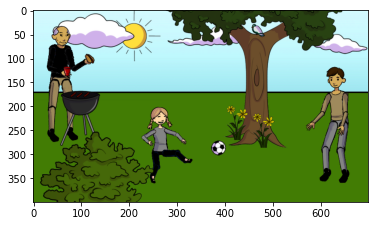

In [ ]:

augmented_img = next(iterator)


image = augmented_img[0]['input_1'][0]   # First element

tf.print (augmented_img[0]['input_2'][0])
tf.print (augmented_img[1][0])

plt.imshow(np.uint8(image))
plt.plot

In [ ]:
#Loading of VGG that will be used as a Backbone
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

# for layer in vgg.layers:
#   layer.trainable = False
freeze_until = 18 # layer from which we want to fine-tune

for layer in vgg.layers[:freeze_until]:
    layer.trainable = False
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400, 700, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 700, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 700, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 350, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 350, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 350, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 175, 128)     0     

In [ ]:
# This function is used for creating a model without skip connections
def create_model():

    model = tf.keras.Sequential()
    model2 = tf.keras.Sequential()
    # Encoder
    # -------
    model.add(vgg)
    model2.add(model_lstm)
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    
    scores = tf.keras.layers.Multiply()([model.output, model2.output])
    
    denso = tf.keras.layers.Dense(units=256, activation='selu')(scores)

    output = tf.keras.layers.Dense(units=58, activation='softmax')(denso)
    
    final_model = tf.keras.Model([model.inputs,model2.inputs], output)


    return final_model

In [ ]:
model = create_model()

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vgg16_input (InputLayer)        [(None, 400, 700, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 12, 21, 512)  14714688    vgg16_input[0][0]                
__________________________________________________________________________________________________
functional_1_input (InputLayer) [(None, 22)]         0                                            
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 512)          0           vgg16[0][0]                      
_______________________________________________________________________________________

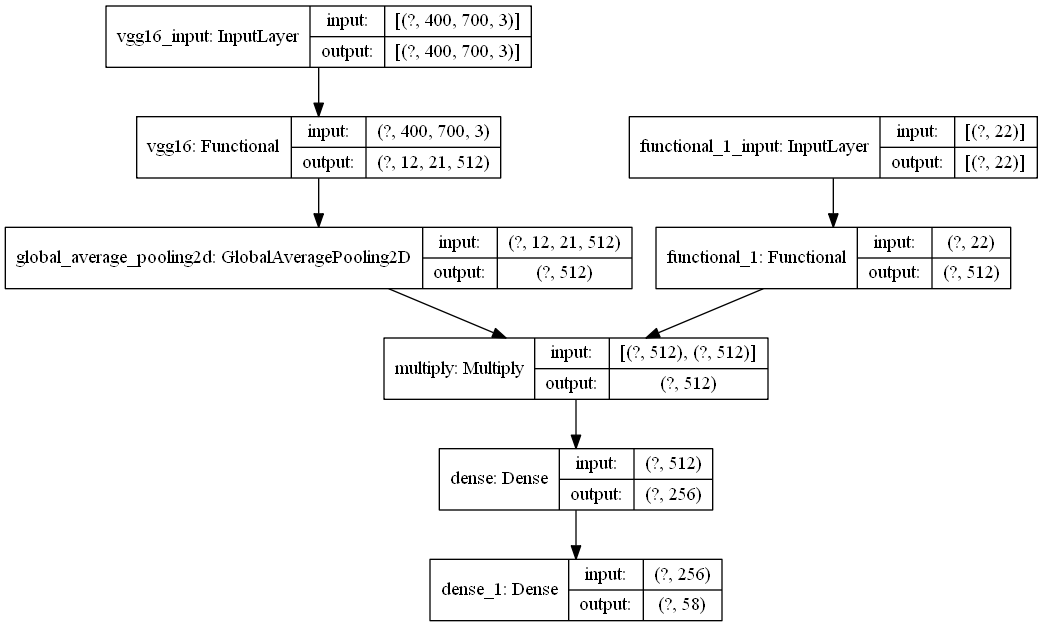

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [ ]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.CategoricalCrossentropy() 


# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------


# Validation metrics
# ------------------
metrics = ['accuracy']
# ------------------



# Compile Model
model.compile(optimizer=optimizer, loss=loss , metrics=metrics)

In [ ]:
import os
from datetime import datetime

cwd1 = os.getcwd()

exps_dir = os.path.join(cwd1, 'multiclass_exps')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
    callbacks.append(es_callback)


model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(dataset)/bs,#+len(dataset1)
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid)/bs, #+len(dataset_valid1)
          callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

Epoch 1/100
3310/3309 [==============================] - 4172s 1s/step - loss: 1.7101 - accuracy: 0.4233 - val_loss: 1.4521 - val_accuracy: 0.4617
Epoch 2/100
3310/3309 [==============================] - 4069s 1s/step - loss: 1.3322 - accuracy: 0.4949 - val_loss: 1.2884 - val_accuracy: 0.5084
Epoch 3/100
3310/3309 [==============================] - 4048s 1s/step - loss: 1.1943 - accuracy: 0.5412 - val_loss: 1.2034 - val_accuracy: 0.5322
Epoch 4/100
3310/3309 [==============================] - 4055s 1s/step - loss: 1.1015 - accuracy: 0.5703 - val_loss: 1.1475 - val_accuracy: 0.5449
Epoch 5/100
3310/3309 [==============================] - 4050s 1s/step - loss: 1.0232 - accuracy: 0.5972 - val_loss: 1.1076 - val_accuracy: 0.5597
Epoch 6/100
3310/3309 [==============================] - 4071s 1s/step - loss: 0.9622 - accuracy: 0.6191 - val_loss: 1.0827 - val_accuracy: 0.5699
Epoch 7/100
3310/3309 [==============================] - 4037s 1s/step - loss: 0.9146 - accuracy: 0.6385 - val_loss: 1

In [ ]:
#Function for creating the result in a csv file

from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:
with open(dataset_QA) as f:
    test_dict = json.load(f)


MAX_NUM_SENTENCES = 70000
MAX_NUM_WORDS = 20000

test_questions = []

# Simplify the dataset
MAX_LEN = 25 # words

# Read all lines in translation dataset
count = 0

for key in test_dict:

#for line in open(os.path.join('/content/drive/My Drive', 'ita.txt'), encoding='utf-8'):
    
    if count > MAX_NUM_SENTENCES:
        break

        
    question = test_dict[key]['question']

    
    if (len(question.split(' ')) > MAX_LEN):
      continue
    
    question = question + ' <eos>'
       
    test_questions.append(question)
    
    count += 1

test_tokenized = ita_tokenizer.texts_to_sequences(test_questions)

# Pad to max italian sentence length
test_encoder_inputs = pad_sequences(test_tokenized, maxlen=max_ita_length)

print("Italian encoder inputs shape:", test_encoder_inputs.shape)

count = 0
for key in test_dict:
    test_dict[key]['question'] = test_encoder_inputs[count]
    count+=1
 

In [ ]:
#Prediction computation done one image at time

#model.load_weights(filepath='C:\\Users\\ASUS\\Documents\\Università\\ANNDL\\A2NDLKaggle\\weights\\FC_Nov14_15-02-54\\ckpts\\cp.ckpt')

from PIL import Image

results = {}
for key in test_dict:
    
    image = tf.keras.preprocessing.image.load_img(test_dir+image_name,target_size=(img_h,img_w))
    # Read Image
    element = test_dict[key]
    image = element['image_id']
    img = Image.open(os.path.join(self.dataset_dir, 'Images', image + '.png'))
    #mask = rme.read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))

    img = img.convert('RGB')
    
    # Resize image and mask
    img = img.resize((img_h,img_w))
    img_arr = np.array(img)
    question = element['question']
    
    pair = {"input_1": img_arr, "input_2": question}  
    
    predictions = model.predict_classes(pair)
    results[key] = predictions[0]

create_csv(results)
print (results)

In [ ]:
model.inputs

In [ ]:
model.save_weights(os.path.join(os.getcwd(),'multiclass_exps/Manual/ckpts/cp.ckpt'))


In [ ]:
train_dataset

<RepeatDataset shapes: ({input_1: (None, 400, 700, 3), input_2: (None, 22)}, (None, 58)), types: ({input_1: tf.float32, input_2: tf.float32}, tf.float32)>